# Linear Regression for Financial Assets with Python Notebook
Gui Larangeira

Based on the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)

Linear regression is a technique that models the relationship between two variables. If we have an independent variable  X , and a dependent outcome variable  Y , linear regression allows us to determine which linear model  Y=α+βX  best explains the data. As an example, let's consider  and SPY. We would like to know how XOM (Exxon) varies as a function of how SPY varies, so we will take the daily returns of each and regress them against each other.


In [15]:
import numpy as np
import pandas as pd
# statsmodels library contains the Linear Regression Models we will use
import statsmodels.api as sm
# If the observations are in a dataframe, you can use statsmodels.formulas.api to do the regression instead
from statsmodels import regression
import matplotlib.pyplot as plt

First we'll define a function that performs linear regression and plots the results.

In [16]:
def linreg(X,Y):
    # Running the linear regression
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    plt.scatter(X, Y, alpha=0.3) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    return model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     190.5
Date:                Mon, 08 May 2017   Prob (F-statistic):           1.47e-32
Time:                        22:59:44   Log-Likelihood:                 863.87
No. Observations:                 251   AIC:                            -1724.
Df Residuals:                     249   BIC:                            -1717.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0007      0.000     -1.384      0.168        -0.002     0.000
x1             0.9575      0.069     13.801      0.000         0.821     1.094
==============================================================================
Omnibus:                       31.653   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.919
Skew:                          -0.396   Prob(JB):                     2.03e-27
Kurtosis:                       6.336   Cond. No.                         141.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

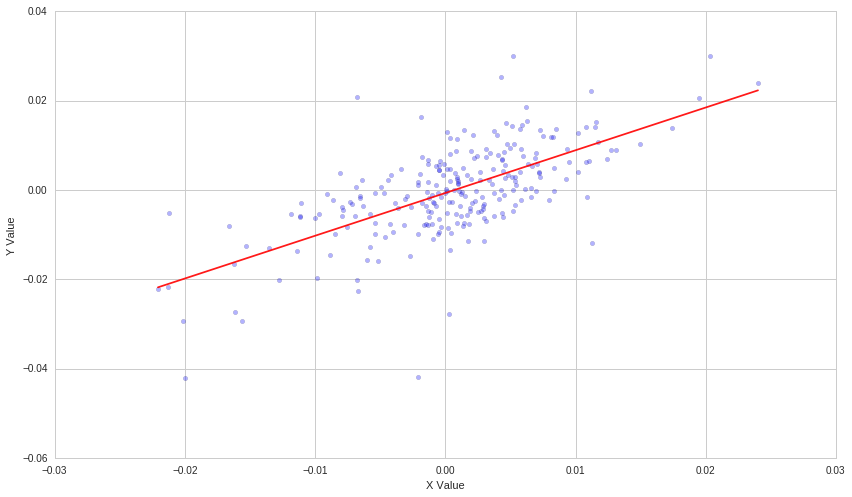

In [20]:
start = '2014-01-01'
end = '2015-01-01'
asset = get_pricing('XOM', fields='price', start_date=start, end_date=end)
benchmark = get_pricing('SPY', fields='price', start_date=start, end_date=end)

# We have to take the percent changes to get to returns
# Get rid of the first (0th) element because it is NAN
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]

linreg(r_b.values, r_a.values)

Multiple linear regression generalizes linear regression, allowing the dependent variable to be a linear function of multiple independent variables. As before, we assume that the variable $Y$ is a linear function of $X_1,\ldots, X_k$:

$$ Y_i = \beta_0 + \beta_1 X_{1i} + \ldots + \beta_k X_{ki} + \epsilon_i $$

For observations $i = 1,2,\ldots, n$. In order to find the plane (or hyperplane) of best fit, we will use the method of ordinary least-squares (OLS), which seeks to minimize the squared error between predictions and observations, $\sum_{i=1}^n \epsilon_i^2$. The square makes makes psositive and negative errors equally bad, and magnifies large errors. For an example of squared error, see the following.

Let's say Y is our actual data, and Y_hat is the predictions made by linear regression.

In [8]:
Y = np.array([1, 3.5, 4, 8, 12])
Y_hat = np.array([1, 3, 5, 7, 9])

print 'Error ' + str(Y_hat - Y)

# Compute squared error
SE = (Y_hat - Y) ** 2

print 'Squared Error ' + str(SE)
print 'Sum Squared Error ' + str(np.sum(SE))

Error [ 0.  -0.5  1.  -1.  -3. ]
Squared Error [ 0.    0.25  1.    1.    9.  ]
Sum Squared Error 11.25


Once we have used this method to determine the coefficients of the regression, we will be able to use new observed values of $X$ to predict values of $Y$. 

Each coefficient $\beta_j$ tells us how much $Y_i$ will change if we change $X_j$ by one while holding all of the other dependent variables constant. This lets us separate out the contributions of different effects. This is assuming the linear model is the correct one.

We use the function regression.linear.model.OLS (Ordinary Least Squares) from `statsmodels`. Running a linear regression on two securities might give a high $\beta$ in the LR model $r_a = \alpha + \beta r_b$. We might also find that they are both highly correlated with the S&P 500. This is useful because the S&P 500 may then be a more reliable predictor of both securities than they were of each other. 

In [9]:
# Load pricing data for two arbitrarily-chosen assets and SPY
start = '2014-01-01'
end = '2015-01-01'
asset1 = get_pricing('AAPL', fields='price', start_date=start, end_date=end)
asset2 = get_pricing('IBM', fields='price', start_date=start, end_date=end)
benchmark = get_pricing('SPY', fields='price', start_date=start, end_date=end)

# First, run a linear regression on the two assets
slr = regression.linear_model.OLS(asset1, sm.add_constant(asset2)).fit()
print 'SLR beta of asset2 in relation to asset1:', slr.params[1]

SLR beta of asset2 in relation to asset1: -0.653943319649


In [10]:
# Run multiple linear regression using asset2 and SPY as independent variables. 
# We then use both "dependent" variables (assets) to predict the independent variable in the LR
mlr = regression.linear_model.OLS(asset1, sm.add_constant(np.column_stack((asset2, benchmark)))).fit()

prediction = mlr.params[0] + mlr.params[1]*asset2 + mlr.params[2]*benchmark
prediction.name = 'Prediction'

print 'MLR beta of asset2:', mlr.params[1], '\nMLR beta of S&P 500:', mlr.params[2]

MLR beta of asset2: -0.200597729348 
MLR beta of S&P 500: 1.38302536519


The next step after running an analysis is determining if we can even trust the results. A good first step is checking to see if anything looks weird in graphs of the independent variables, dependent variables, and predictions.

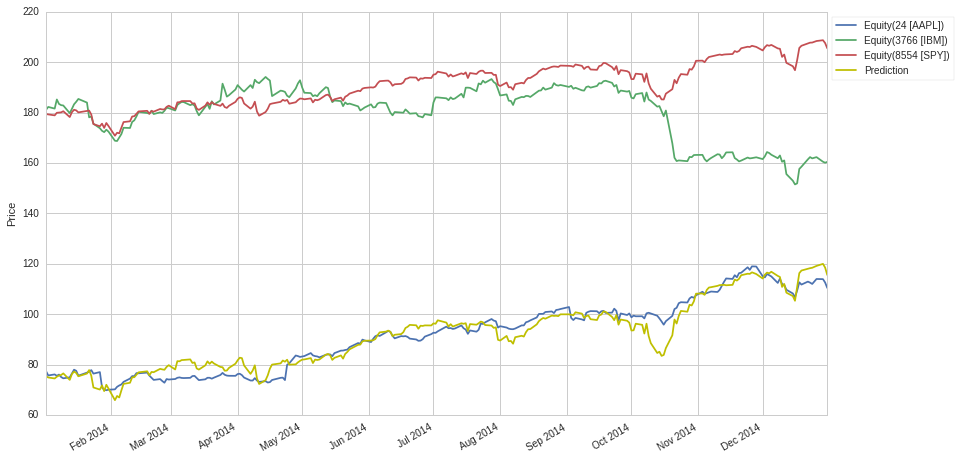

In [11]:
# Plot the three variables along with the prediction given by the MLR
asset1.plot()
asset2.plot()
benchmark.plot()
prediction.plot(color='y')
plt.ylabel('Price')
plt.legend(bbox_to_anchor=(1,1), loc=2);

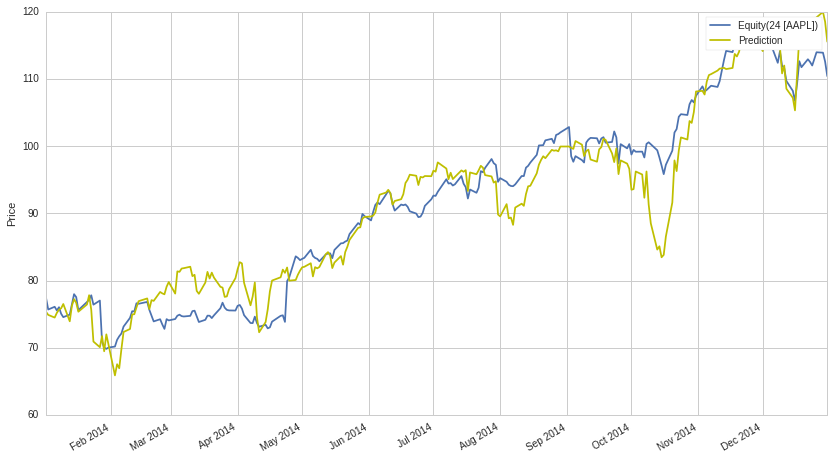

In [12]:
# Plot only the dependent variable and the prediction to get a closer look
asset1.plot()
prediction.plot(color='y')
plt.ylabel('Price')
plt.legend();

# Evaluation
We can get some statistics about the fit from the result returned by the regression:

In [13]:
mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Equity(24 [AAPL])   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     1440.
Date:                Mon, 08 May 2017   Prob (F-statistic):          1.38e-137
Time:                        22:36:53   Log-Likelihood:                -699.54
No. Observations:                 252   AIC:                             1405.
Df Residuals:                     249   BIC:                             1416.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -136.5007      8.654    -15.773      0.000      -153.545  -119.456
x1            -0.2006      0.025     -7.980      0.000        -0.250    -0.151
x2             1.3830      0.030     45.589      0.000         1.323     1.443
==============================================================================
Omnibus:                       22.276   Durbin-Watson:                   0.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.719
Skew:                           0.571   Prob(JB):                     7.86e-08
Kurtosis:                       4.346   Cond. No.                     9.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""